# drifting context branch

In [112]:
import numpy as np
import tensorflow as tf

from pureEM import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### todo
- embedding matrix is placeholder

In [141]:
T,X,Y = task.gen_episode()
X

array([[1, 0, 1, 0, 1]])

-- proportion of true trials: M=0.25 S=0.17


/Users/abeukers/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/abeukers/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(array([[       nan,        nan,        nan,        nan,        nan],
        [       nan, 1.        , 0.61237244, 0.40824829, 0.25      ],
        [       nan, 0.61237244, 1.        , 0.66666667, 0.40824829],
        [       nan, 0.40824829, 0.66666667, 1.        , 0.61237244],
        [       nan, 0.25      , 0.40824829, 0.61237244, 1.        ]]),
 array([[1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]]))

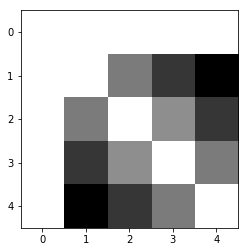

In [86]:
""" 
memory debugger: 
  generate data to assess the retrieval behavior of the network
"""

ntrials = 5
edim = ntrials
nstim = x10

task = NBackTask(nstim=nstim,ntrials=ntrials,flip_pr=.35)
net = PureEM(nstim=nstim,ntrials=ntrials,discount_rate=0.9,edim=ntrials)

context_emat = np.triu(np.ones([ntrials,edim]))
T,X,Y = task.gen_episode()

feed_dict = {
  net.trial_ph:T,
  net.stim_ph:X,
  net.y_ph:Y,
  net.context_emat_ph:context_emat
}

ops = [
      net.minimizer,
      net.train_loss,
      net.response,
      net.retrieved_memory
    ]

outs = net.sess.run(ops,feed_dict)
    


In [143]:
def train_loop(net,task,epochs=10000):
#   context_emat = np.triu(np.ones([net.ntrials,net.context_edim]))
  context_emat = np.random.randn(net.ntrials,net.context_edim)
  print(context_emat)
  # arrays
  L = -1*np.ones(epochs)
  A = -1*np.ones(epochs)
  for ep in range(epochs): 
    T,X,Y = task.gen_episode()
    feed_dict = {
      net.trial_ph:T,
      net.stim_ph:X,
      net.y_ph:Y,
      net.context_emat_ph:context_emat
    }
    ops = [
      net.minimizer,
      net.train_loss,
      net.response,
      net.retrieved_memory
    ]
    # record loss and accuracy
    outs = net.sess.run(ops,feed_dict)
    _,loss,yhat,m_T = outs

    L[ep] = loss.mean()
    A[ep] = np.mean(yhat==Y[:,2:])
  return L,A


In [ ]:
ntrials = 5
nstim = 5
epochs = 50000
discount_rate = 0.9
dim = 25
stim_edim = 25
context_edim = ntrials

net = PureEM(nstim,ntrials,dim,stim_edim,context_edim,discount_rate)
task = NBackTask(nstim=nstim,ntrials=ntrials,flip_pr=.5)
L,A = train_loop(net,task,epochs)

semat untrainable
-- proportion of true trials: M=0.36 S=0.17
[[ 0.74179634  0.39106912 -0.25947739  1.31395936 -1.64161931]
 [-1.08926781 -1.39598072  0.03994865  0.29662519  0.3094476 ]
 [-0.23800718  0.69126033 -1.62307339  1.19280716 -0.20141691]
 [ 0.13144558  1.60173807 -0.55240839  0.33046951 -0.40868672]
 [-0.20766396  0.64571091  0.75687344 -0.29112485  1.61228027]]


In [ ]:
plt.figure(figsize=(14,4))
ax = plt.gca()
ax.plot(L)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax2 = ax.twinx()
ax2.scatter(range(len(A)),A,c='r')
ax2.set_ylabel('accoracy')
plt.title('context not trainable')
# plt.savefig('figures/pureem-shifting_context/train_lossacc-trainable_context')


### simulating chance

proportion of true trials: M=0.39 S=0.14


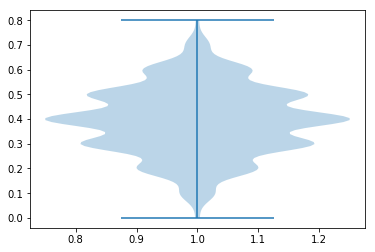

In [749]:
ntrials = 10
nstim = 5
true_nback_pr = .35
task = NBackTask(nstim=nstim,ntrials=ntrials,true_nback_pr=true_nback_pr)

L = []
for i in range(1000):
  T,X,Y = task.gen_episode()
  L.append(Y.sum()/Y.shape[1])

plt.violinplot(L)
print("proportion of true trials: M=%.2f S=%.2f"%(np.mean(L),np.std(L)))

### debugging

In [679]:
ntrials=5
net = PureEM(ntrials=ntrials,dim=2)
# task = NBackTask()
# net.reinitialize()
ntrials=5
for ep in range(1): 
  T,X,Y = task.genseq(ntrials=ntrials)
  feed_dict = {net.trial_ph:T,net.stim_ph:X,net.y_ph:Y}
  ops = [
    net.M_keys,
    net.query_key_sim,
    net.stim,
    net.retrieved_memory,
    net.M_values,
    net.context,
    net.response_in
  ]
  outs = net.sess.run(ops,feed_dict)

Tensor("strided_slice_2:0", shape=(1, 2), dtype=float32)
Tensor("strided_slice:0", shape=(2, 2), dtype=float32)
[1.0, 0.9]
Tensor("strided_slice_4:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write:0", shape=(3, 2), dtype=float32)
[0.9, 1.0, 0.9]
Tensor("strided_slice_6:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write_1:0", shape=(4, 2), dtype=float32)
[0.81, 0.9, 1.0, 0.9]


In [680]:
# stim seq
for x in X.squeeze():
  print(x)

1
2
0
2
2


In [681]:
print('cos')
print(outs[1].round(3))
# s_t

# sim

print('M_K')
print(outs[0])
print('stim_T')
print(outs[2][:,-1])
print('M_V')
print(outs[4])
print('m_T')
print(outs[3])
print('c_T')
print(outs[5][:,-1])
print('x_in')
print(outs[6].reshape(2,-1))

cos
[0.004 0.4   0.196 0.4  ]
M_K
[[ 0.11894773  0.9486887 ]
 [-0.27373168 -0.96113366]
 [-0.6422192   0.66132146]
 [-0.27373168 -0.96113366]
 [-0.27373168 -0.96113366]]
stim_T
[[-0.27373168 -0.96113366]]
M_V
[[ 0.5238827  -0.00179951]
 [-0.33924514  0.18750945]
 [-0.89836234 -0.76285404]
 [-0.7214177  -0.03025485]
 [-0.0098532   0.42147025]]
m_T
[[-0.59812367 -0.08630171]]
c_T
[[-0.0098532   0.42147025]]
x_in
[[-0.0098532   0.42147025]
 [-0.59812367 -0.08630171]]


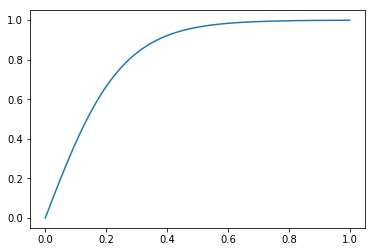

In [592]:
x = np.linspace(0,1,100)
t=4
y=np.tanh(t*x)
plt.plot(x,y)